__Задание__

В рамках этого итогового задания мы будем прогнозировать сердечную недостаточность.

Плана по выполнению задания не будет. 
Но есть несколько требований: 

- оберните весь конвейер преобразований в Pipeline

- подберите оптимальный вариант прогнозной модели с помощью GridSearchCV

- примените обученный на тренировочных данных конвейер к тестовым данным, никак не предобрабатывая их, а лишь загрузив из файла и отделив целевой признак от остальных

- получите на тестовой части качество не ниже 0.87 по метрике ROCAUC

Пояснение: если пропуски в новых данных и будут, то только в тех колонках, где они есть в тренировочной части.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas as pd
from scipy import stats
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from summarytools import dfSummary

Загружаем данные обучающей выборки и проводим цикл анализа данных (EDA):

In [2]:
train = pd.read_csv('heart_adapt_train.csv')

# Переименуем названия столбцов в соответствии с PEP8
train.columns = [re.sub('(?<!^)(?=[A-Z])|[ ]', '_', i, count=1).lower() for i in train.columns]
train.rename(columns={'s_t_slope': 'st_slope'}, inplace=True)
train.sample(3)

,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
3,50.0,M,ASY,144.0,349.0,0,LVH,120,Y,1.0,Up,1
444,62.0,M,ASY,135.0,297.0,0,Normal,130,Y,1.0,Flat,1
186,69.0,M,NAP,140.0,254.0,0,LVH,146,N,2.0,Flat,1


In [3]:
# Возвращаем размерность
train.shape

(589, 12)

- Данные представляют собой тренировочный набор информации о состоянии сердечно-сосудистой системы пациентов, который может быть использован для обучения моделей предсказания наличия ишемической болезни сердца.

- Таргет heart_disease представляет собой бинарную или двухклассовую переменную, где 0 означает отсутствие сердечной недостаточности, а 1 означает наличие сердечной недостаточности.

Таким образом, эта задача является задачей бинарной классификации.

DataFrame состоит из 12 столбцов, представляющих различные характеристики сердечно-сосудистого здоровья пациентов.

   - Age: возраст пациента в годах.
   - Sex: пол пациента (M - мужской, F - женский).
   - ChestPainType: тип болей в груди пациента (NAP - типичная стенокардия, ASY - безболевая ишемия, TA - атипичная стенокардия, ATA - атипичная стенокардия может подразумевать более выраженные или отличительные характеристики данного состояния).
   - RestingBP: артериальное давление пациента в состоянии покоя.
   - Cholesterol: уровень холестерина в крови пациента в данном случае уровень холестерина измеряется в миллиграммах на децилитр (мг/дл)
   - FastingBS: уровень глюкозы в крови пациента в состоянии голода (0 - норма, 1 - повышен).
   - RestingECG: результат электрокардиографического исследования в состоянии покоя (Normal - нормальный, ST - наличие изменений сегмента ST изменения сегмента ST могут указывать на ишемию миокарда, LVH - Гипертрофия (увеличение размера) левого желудочка сердца может быть вызвана различными заболеваниями, такими как артериальная гипертензия, пороки сердца, кардиомиопатии и другими).
   - MaxHR: максимальная частота сердечных сокращений пациента.
   - ExerciseAngina: наличие или отсутствие стенокардии при физической нагрузке (Y - да, N - нет).
   - Oldpeak: смещение сегмента ST во время нагрузочной пробы.
   - ST_Slope: наклон сегмента ST во время нагрузочной пробы (Up - вверх, Flat - плоский, Down - вниз).
   - HeartDisease: наличие или отсутствие ишемической болезни сердца (1 - есть, 0 - нет).

Таким образом, данные представляют собой информацию о состоянии сердечно-сосудистой системы пациентов, которая может быть использована для анализа и построения моделей предсказания наличия ишемической болезни сердца.

In [4]:
# Применим библиотеку dfSummary к датафрейму обучающей выборки
dfSummary(train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[float64],Mean (sd) : 54.2 (9.5)min < med < max:28.0 < 55.0 < 77.0IQR (CV) : 13.0 (5.7),49 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACqUlEQVR4nO3cP47aQBSA8TdhQQYUI0QEnS8QKQUlTW6Qw6ZNlwIuwA1oEBICI5y1MMYpokgo2uziP7PMG75f72WKT8jDzjxTFIUArvtw7wUAt3i69wJ8ZIzpikin4uOnoiiem1yPDwi1YcaY7mg0+haG4bDK8/v9/miM+SEiacUleBk6oTavE4bhcDabPQ8Gg1Kxrdfrj4vF4msURZ9arValUA+Hw84Y8923WAnVksFgkI7H419lntntdt0gCHrT6TSdTCa7sp8Zx3Ewn8+H2+22IyKECrv6/X7pyK90G12MI9j1QwVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqcCjlP2ocfg4vl0u76fU8OkJ9QZ3Dz1mWBXmef07T9KeIVD0BhX8Q6ssqH35erVbD5XLZO5/PLVuLe0SE+oqqh59treeRsZmCCoQKFQgVKhAqVCBUqECoUIFQoQK/o3omz/O2iITGmCqPOzsOiFA9kiRJO8uyL1EUtaqMBHJ5HBCheuR0Oj1VHQnk+jggQvVQjZFAzv77l80UVCBUqECoUIFQoYK3m6mac/S5TuIYL0OtO0ef6yTu8TJUqXGVRITrJC7yNVQRqXaVRITrJC5iMwUVCBUqECpUcPodlWkl+MvZUJlWgmvOhipMK8EVl0MVEaaV4A82U1CBUKECoUIFQoUKhAoVnN/14/3UnAkgYnEugNVQObysR92ZACJ25wJYC5XDy7rUmQkgYn8ugM1vVA4vK1RjJoCIxbkA1t9RObyMJrDrhwqEChUIFSoQKlTgB380xuYQYUJFI2wPEX4zVO4t4Ra2hwi/Gir3llCWrSHCb32jcm8JTrjpHZV7S7i3m0KN4zgo+4ePx2MgIpIkSbDZbHrv+bzWz9a67rrP39LXb4WVoyp9HOt8AAAAAElFTkSuQmCC"">",56(9.5%)
2,sex[object],1. M2. F,477 (81.0%)112 (19.0%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAAuCAYAAAA/ZmtKAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABLElEQVR4nO3bwWnDQBBG4dkgTHzZRQhcjIpIsSliuxFCe4iNL8ohPbwJ6H0NjMHPBhv95TzPkAglIu4Rcct+IcK9z/N8kgenZVm+aq0zeVT5xhh7KeWbDG6qtc7ruj5bay/qqHIdx/HZe5+3bbtFBBdbRERr7fV4PH6oo/oX7vTBD/qgrsvYhDE2YYxNGGMTxtiEMTZhjE0YYxPG2IQxNmGMTRhjE8bYhDE2YaaIv4fpsl+IOFnv9zTG2HvvcyQ8TKc8Y4w9It7kTQcv14UPXopTPlGyvtnwT5XypUz5MmZkyodP+bJmZMqXNeXzl+8F+aeuMMYmjLEJY2zCGJswxiaMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJg0/5nA1eV8qUL2NGpnwOXoT5BQpbat9IhQyXAAAAAElFTkSuQmCC"">",0(0.0%)
3,chest_paintype[object],1. ASY2. NAP3. ATA4. TA,348 (59.1%)117 (19.9%)96 (16.3%)28 (4.8%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABcCAYAAAB5jMeAAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAB6klEQVR4nO3bQWrbUBSF4atiQjORMQYvxovoYrsI7cYYa9CETNRByTDJRDkPer9vBQ/zIyPxzrRtW0HCj9EHoA+xETNV1XNVPY0+SCNv27a9jD7ECIfz+fxrnufT6IN0sa7rfZqm3x2DO8zzfLpery/H4/F19GH+d4/H4+eyLKfb7fZUVf1iq6o6Ho+vl8vlz+jDNPE8+gCjeEEgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmIOVf+uvow+SAfdf+fDuq73ZVlO1fjqS9K6rveqeht9jhFcC89rey18MuUjxQsCMaP/Rtv+pXQ0dF3VeWnU0bB1VfelUUej11U+tzTiBYEYsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMcOmfN1nbR0NnfJ1nrV1ZINAjCkfMaknmycYmXWVFRVVgXWVFRXvUusqKyp81CVHbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGzLevq6yoeBdZV1lRUWWDQJB1FTFfPdk8kdjNp+sqqyj29OG6yiqKvX21rrKKYjc+6hIjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERozYiBEbMWIj5sN1lVUUe/t0XWUVxZ5sEIixriLGCwIxfwGzWNi5cF/09AAAAABJRU5ErkJggg=="">",0(0.0%)
4,resting_bp[float64],Mean (sd) : 133.4 (18.9)min < med < max:80.0 < 130.0 < 200.0IQR (CV) : 24.0 (7.1),61 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAACr0lEQVR4nO3dT47aMBiH4Z/LnwaQghAV7LhApS5YcogetkcoEifgBuyQEAoiHQQEuuliRmKmxU6Kv/A+eytZvBphj+246/UqIHafHv0CwL9oPvoFYuWc60hqew4/Xq/XlzLf59kR6g3Ouc5wOPyepunAZ/xut9s6534Qa3kI9bZ2mqaD2Wz20u/3D/cMzLIsWSwWg81m05ZEqCUh1A/0+/3DaDT65TG0U/rLPDkmUzCBUGECocKE2v5GDVxeSi+XS8v32UVRtCSlzjmf4Sxt3VDLUEOXl06nU1IUxdfD4fBT0l2TqTzPW6fT6dtkMmk0Go27VgwklrbeU8tQFbC8JEmr1WqwXC675/O5ce/Y4/HYTJKkO51OD+PxeHvPWJa23lfXUCX5Ly9tt9vg5aVer8fSVomYTMEEQoUJhAoTCBUmECpMIFSYQKgwgVBhAqHCBEKFCYQKEwgVJhAqTCBUmECoMIFQYQKhwgRChQmEChMIFSYQKkwgVJhAqDAh6nP9AdfyBF3Jg/hEG2rItTwhV/IgTtGGqoBreUKu5EGcYg5Vkt+1PGVcyYO4MJmCCYQKEwgVJhAqTCBUmBD9rP/ZBN7/L9X0GwCEGpHQ+/+l+n4DgFAjEnL/v1TvbwAQaoQC7v+XavoNACZTMIFQYQ

In [5]:
display(train.loc[train['resting_bp'].isna()]) # выводим строки, в которых есть пропущенные значения в столбце resting_bp:

,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
232,55.0,M,NAP,NaN,NaN,0,Normal,155,N,1.5,Flat,1


Заполним артериальное давление пациента медианой в соответствии с пояснением задания

In [6]:
train.resting_bp = train.resting_bp.fillna(train.resting_bp.median()) 

In [7]:
display(train.loc[train['age'].isna()]) # выводим строки, в которых есть пропущенные значения в столбце age:

,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
4,NaN,M,ASY,145.0,248.0,0,Normal,96,Y,2.0,Flat,1
21,NaN,M,ATA,120.0,284.0,0,Normal,118,N,0.0,Up,0
28,NaN,M,ASY,140.0,276.0,1,Normal,125,Y,0.0,Up,0
30,NaN,M,NAP,150.0,212.0,1,Normal,157,N,1.6,Up,0
38,NaN,M,TA,140.0,199.0,0,Normal,178,Y,1.4,Up,0
41,NaN,M,ASY,130.0,131.0,0,Normal,115,Y,1.2,Flat,1
45,NaN,M,ATA,130.0,215.0,0,Normal,135,N,0.0,Up,0
48,NaN,M,ASY,95.0,NaN,1,Normal,182,N,0.7,Down,1
62,NaN,M,ASY,136.0,225.0,0,Normal,112,Y,3.0,Flat,1
77,NaN,M,ASY,124.0,260.0,0,ST,112,Y,3.0,Flat,0


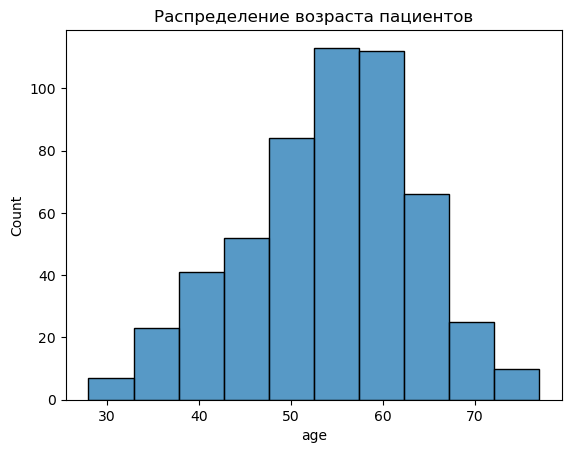

In [8]:
sns.histplot(train['age'], bins = 10)
plt.title('Распределение возраста пациентов');

In [9]:
_, pvalue = stats.shapiro(train['age'])

alpha = .05

if pvalue < alpha:
    print(f'P-value:{pvalue:.5f}. Нулевая гипотеза отвергается')
else:
    print(f'P-value:{pvalue:.5f}. Подтверждается нулевая гипотеза')

P-value:nan. Подтверждается нулевая гипотеза


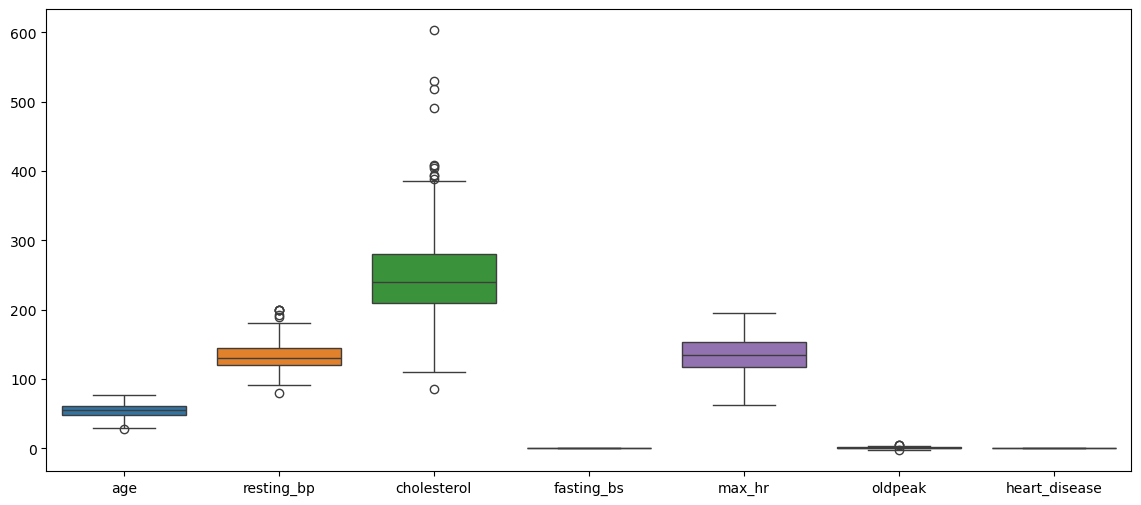

In [10]:
plt.figure(figsize=(14,6)) # Изменяем размер графика
sns.boxplot(train); # Смотрим графики распределения для обучающей выборки

Видим выбросы в столбце уровня холестерина в крови пациента, построим скетерплот для более детального анализа

In [11]:
# Создание графика рассеяния с линией тренда OLS
fig = px.scatter(
    train, 
    x="age", 
    y="cholesterol", 
    trendline="ols",  # Добавление линии тренда OLS
    color="sex",  # Цвет для различия полов
    title="Взаимосвязь между возрастом и уровнем холестерина"
)

# Настройка подписей осей
fig.update_layout(
    xaxis_title="Возраст",
    yaxis_title="Уровень холестерина",
    legend_title="Пол"
)

# Добавление аннотации (пример)
highest_chol = train[train['cholesterol'] == train['cholesterol'].max()]
fig.add_annotation(
    x=highest_chol['age'].values[0],
    y=highest_chol['cholesterol'].values[0],
    text="Максимальный уровень холестерина",
    showarrow=True,
    arrowhead=2,
    ax=-40,  # Смещение по оси X
    ay=-30,  # Смещение по оси Y
    bgcolor="white",
    font=dict(size=14)
)

# Установка сетки для улучшения читаемости
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Отображение графика
fig.show()

In [12]:
display(train.loc[train['cholesterol'] == 603].head()) # отображаем информацию про cholesterol со значением 603 мг/дл
display(train.loc[train['cholesterol'] == 529].head()) # отображаем информацию про cholesterol со значением 529 мг/дл
display(train.loc[train['cholesterol'] == 518].head()) # отображаем информацию про cholesterol со значением 518 мг/дл
display(train.loc[train['cholesterol'] == 491].head()) # отображаем информацию про cholesterol со значением 491 мг/дл

,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
182,54.0,M,ASY,130.0,603.0,1,Normal,125,Y,1.0,Flat,1


,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
123,32.0,M,ASY,118.0,529.0,0,Normal,130,N,0.0,Flat,1


,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
312,53.0,M,NAP,145.0,518.0,0,Normal,130,N,0.0,Flat,1


,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
197,44.0,M,ASY,135.0,491.0,0,Normal,135,N,0.0,Flat,1


Значение 603.0, 529.0, 518.0, 491.0 для столбца "cholesterol" выглядят как выбросы. Стандартное отклонение составляет 58.6, а диапазон от 85.0 до 603.0 достаточно велик, что указывает на наличие аномальных значений. Удалим их из датафрейма.

In [13]:
train.drop(train[train['cholesterol'] == 603].index, inplace=True) # удаляем cholesterol со значением 603 мг/дл
train.drop(train[train['cholesterol'] == 529].index, inplace=True) # удаляем cholesterol со значением 603 мг/дл
train.drop(train[train['cholesterol'] == 518].index, inplace=True) # удаляем cholesterol со значением 603 мг/дл
train.drop(train[train['cholesterol'] == 491].index, inplace=True) # удаляем cholesterol со значением 603 мг/дл

In [14]:
# Создание графика рассеяния с линией тренда LOWESS
fig = px.scatter(
    train, 
    x="age", 
    y="max_hr", 
    trendline="lowess",  # Добавление линии тренда LOWESS
    color="sex",  # Использование цвета для различия полов
    title="Взаимосвязь между возрастом и максимальной частотой сердечных сокращений пациента"
)

# Настройка подписей осей
fig.update_layout(
    xaxis_title="Возраст",
    yaxis_title="Максимальная частота сердечных сокращений",
    legend_title="Пол"
)

# Установка сетки для улучшения читаемости
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Отображение графика
fig.show()

In [15]:
# Создание графика рассеяния с регрессионной линией
fig = px.scatter(
    train, 
    x="age", 
    y="resting_bp", 
    color="sex",  # Используем цвет для различия пола
    title="Взаимосвязь между возрастом и артериальным давлением пациента в состоянии покоя",
    trendline="ols"  # Добавление линии тренда
)

# Настройка подписей осей
fig.update_layout(
    xaxis_title="Возраст",
    yaxis_title="Артериальное давление в состоянии покоя",
    legend_title="Пол"
)

# Установка сетки для улучшения читаемости
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Отображение графика
fig.show()

In [16]:
# Создание гистограммы
fig = px.histogram(
    train, 
    x="age", 
    color="sex", 
    pattern_shape="sex", 
    title="Наличие ишемической болезни сердца у пациентов"
)

# Настройка подписей осей
fig.update_layout(
    xaxis_title="Возраст",
    yaxis_title="Количество случаев",
    legend_title="Пол"
)

# Добавление аннотации (пример, если вы знаете важные возрастные группы)
fig.add_annotation(
    x=58,
    y=50,  # само значение нужно будет скорректировать
    text="Высокий риск!",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-40,
    bgcolor="white",
    font=dict(size=14)
)

# Установка сетки
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# Отображение графика
fig.show()

In [17]:
train.shape

(585, 12)

Загрузим тестовую выборку и переименуем названия столбцов в соответствии с PEP8

In [18]:
test = pd.read_csv('heart_adapt_test.csv')

# Переименуем названия столбцов в соответствии с PEP8
test.columns = [re.sub('(?<!^)(?=[A-Z])|[ ]', '_', i, count=1).lower() for i in test]
test.rename(columns={'s_t_slope': 'st_slope'}, inplace=True)
test.sample(3)

,age,sex,chest_paintype,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
174,52.0,M,NAP,172.0,199.0,1,Normal,162,N,0.5,Up,0
127,45.0,M,ASY,120.0,225.0,0,Normal,140,N,0.0,Up,0
17,62.0,F,ASY,140.0,268.0,0,LVH,160,N,3.6,Down,1


In [19]:
test.shape

(197, 12)

In [20]:
# Определяем размер обучающей и тестовой выборок
train_size = train.shape[0]  # Количество образцов в обучающей выборке
test_size = test.shape[0]     # Количество образцов в тестовой выборке
total_size = train_size + test_size  # Общий размер выборок

# Рассчитываем процентное соотношение
train_percentage = (train_size / total_size) * 100  # Процент обучающей выборки
test_percentage = (test_size / total_size) * 100     # Процент тестовой выборки

# Выводим результаты
print(f"Размер обучающей выборки: {train_size} ({train_percentage:.2f}%)")
print(f"Размер тестовой выборки: {test_size} ({test_percentage:.2f}%)")


Размер обучающей выборки: 585 (74.81%)
Размер тестовой выборки: 197 (25.19%)


Отделяем признаки от таргета.

In [21]:
# Определение целевой переменной и признаков
train_target = train['heart_disease']
train_features = train.drop(['heart_disease'], axis=1)
test_target = test['heart_disease']
test_features = test.drop(['heart_disease'], axis=1)

In [22]:
# Посмотрим на уникальные значения категориальных признаков
for column in train.select_dtypes(include=['object']).columns:
    print(f"{column}:", train[column].unique())

sex: ['M' 'F']
chest_paintype: ['NAP' 'ATA' 'ASY' 'TA']
resting_ecg: ['Normal' 'LVH' 'ST']
exercise_angina: ['N' 'Y']
st_slope: ['Up' 'Flat' 'Down']


In [23]:
# Определение категориальных и числовых столбцов
categorical_cols = train_features.select_dtypes(include=['object']).columns.tolist()
numerical_cols = train_features.select_dtypes(exclude=['object']).columns.tolist()

In [24]:
# Создаем общий предобработчик с трансформерами для числовых и категориальных данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков
            ('scaler', StandardScaler())  # Стандартизация числовых признаков
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Заполнение пропусков для категориальных
            ('ohe', OneHotEncoder(handle_unknown='ignore'))  # Одноразовое кодирование категориальных признаков
        ]), categorical_cols)
    ]
)

In [25]:
# Теперь создаем полный пайплайн с классификаторами
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classify', LogisticRegression(class_weight='balanced', random_state=0))
])

# Параметры для GridSearchCV
params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)],
     'classify__C': [0.01, 0.1, 1, 10, 100]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)],
     'classify__max_depth': [2, 5, 10, 20]},
]

# Поиск лучших гиперпараметров на тренировочных данных
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=train_features, y=train_target)

# Получаем информацию о наилучшей модели
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Получаем предсказания меток классов и вероятностей на тестовых данных
test_pred_proba = best_model.predict_proba(test_features)[:, 1]
test_pred = best_model.predict(test_features)

# Оценка качества модели на тестовой выборке
roc_auc = roc_auc_score(test_target, test_pred_proba)

# Выводим отчет о качестве классификации для лучшей модели
print("Лучшие параметры модели:")
if isinstance(best_model.named_steps['classify'], LogisticRegression):
    model_name = "LogisticRegression"
    model_params = f"Регуляризационный параметр модели: C = {best_params['classify__C']}"
elif isinstance(best_model.named_steps['classify'], DecisionTreeClassifier):
    model_name = "DecisionTreeClassifier"
    model_params = f"max_depth = {best_params['classify__max_depth']}"

print(f"Используемая модель: {model_name}")
print(model_params)
# Выводим отчет о качестве классификации
print("\nОтчет о качестве классификации:")
print(classification_report(test_target, test_pred))

# Вычисляем и выводим метрику ROC-AUC
print(f"\nROC-AUC Score: {roc_auc:.2f}")

Лучшие параметры модели:
Используемая модель: LogisticRegression
Регуляризационный параметр модели: C = 0.1

Отчет о качестве классификации:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        70
           1       0.91      0.91      0.91       127

    accuracy                           0.88       197
   macro avg       0.87      0.87      0.87       197
weighted avg       0.88      0.88      0.88       197


ROC-AUC Score: 0.91


### Вывод:

#### 1. Тип используемой модели:
   - Примененная модель: Логистическая регрессия. Это популярный метод для бинарной классификации, который показывает хорошие результаты при наличии линейной зависимости между признаками.

#### 2. Параметры модели:
   - Использованные параметры: 
     - class_weight=balanced: Данный параметр помогает сбалансировать классы в случае, если они не равномерны, что улучшает общую производительность модели при работе с несбалансированными данными.
     - random_state=0: Этот параметр обеспечивает воспроизводимость результатов, позволяя получать те же результаты при повторном обучении модели.

   - Регуляризационный параметр (C = 0.1): Низкое значение C указывает на более сильную регуляризацию, что может помочь избежать переобучения, особенно если обучающая выборка содержит шум или много признаков.

#### 3. Качество классификации:
   - Precision (точность):
     - Класс 0: 0.83
     - Класс 1: 0.91

     Высокий уровень точности для обоих классов указывает на то, что модель хорошо распознает положительные примеры (класс 1) и достаточно точно классифицирует отрицательные примеры (класс 0).

   - Recall (полнота):
     - Класс 0: 0.83
     - Класс 1: 0.91

     Значения полноты также высокие, что говорит о способности модели правильно находить объекты обоих классов.

   - F1-score:
     - Класс 0: 0.83
     - Класс 1: 0.91

     F1-score является сбалансированной мерой точности и полноты, и его высокие значения подтверждают общее хорошее качество классификации модели.

   - Accuracy (точность): Общая точность модели составляет 88%, что является впечатляющим показателем.

   - Средние показатели:
     - Macro average: 0.87 (средние значения без учета дисбаланса классов)
     - Weighted average: 0.88 (с учетом дисбаланса классов, взвешенный по количеству примеров в каждом классе)

#### 4. ROC-AUC Score:
   - Значение ROC-AUC составляет 0.91, что свидетельствует о том, что модель имеет отличные характеристики при различении классов. Это показатель указывает на высокую вероятность успешного различения положительных и отрицательных классов.

#### <span style="color: orange; font-weight: bold;">Заключение:</span>

В целом, модель логистической регрессии с указанными параметрами демонстрирует хорошие результаты по всем метрикам. Применение параметров, таких как class_weight=balanced, помогает справиться с проблемами несбалансированных данных, а регуляризация с параметром C=0.1 эффективно контролирует переобучение. 

Рекомендуется продолжить тестирование модели на новых данных и, возможно, рассмотреть другие алгоритмы или настройки, чтобы увидеть, можно ли достичь еще лучших результатов.